In [3]:
#导入数据处理、可视化、机器学习模型和评估指标所需的库
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from warnings import simplefilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
simplefilter("ignore")
data= pd.read_csv('/kaggle/input/water-potability/water_potability.csv')
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [4]:
data_count = data.isnull().sum()
print(data_count[0:10])
print(f'The dataset has {data.isna().sum().sum()} null values.')

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64
The dataset has 1434 null values.


In [5]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


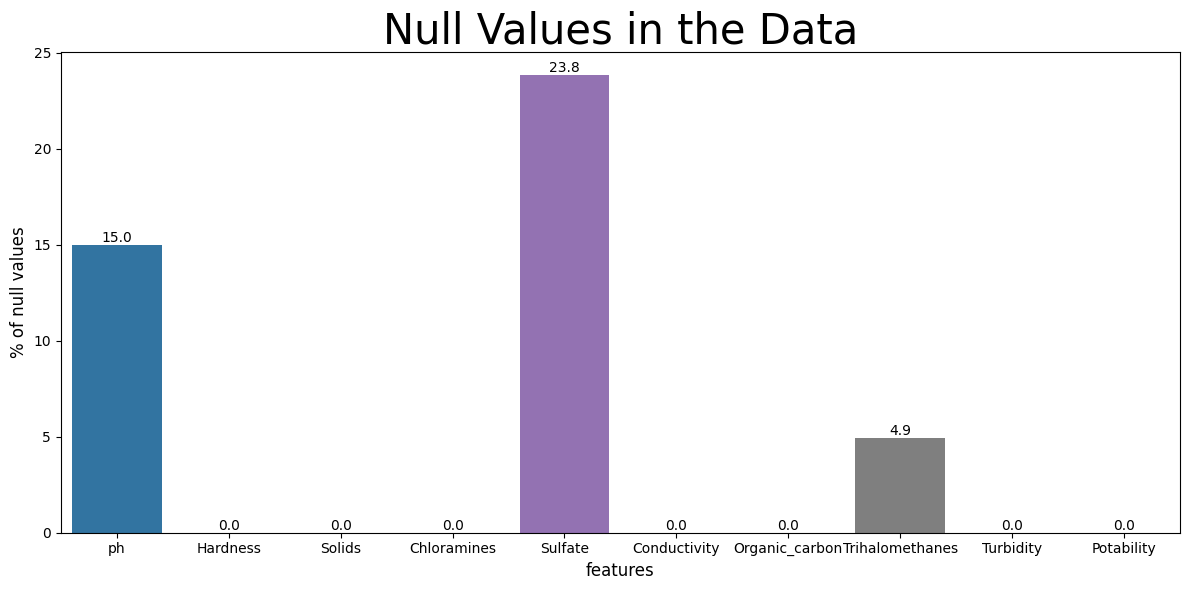

In [6]:
#柱状图筛选缺失严重的列
null_proportion=(data_count/len(data))*100
#转为dataframe并整理索引
null_proportion=null_proportion.reset_index(name='count')

#画布大小
fig = plt.figure(figsize=(12,6))

fig = sns.barplot(null_proportion, x="index", y="count")
fig.set_title('Null Values in the Data', fontsize=30)
fig.set_xlabel('features', fontsize=12)
fig.set_ylabel('% of null values', fontsize=12)
fig.bar_label(fig.containers[0], fmt='%.1f')
#自动优化布局
plt.tight_layout()

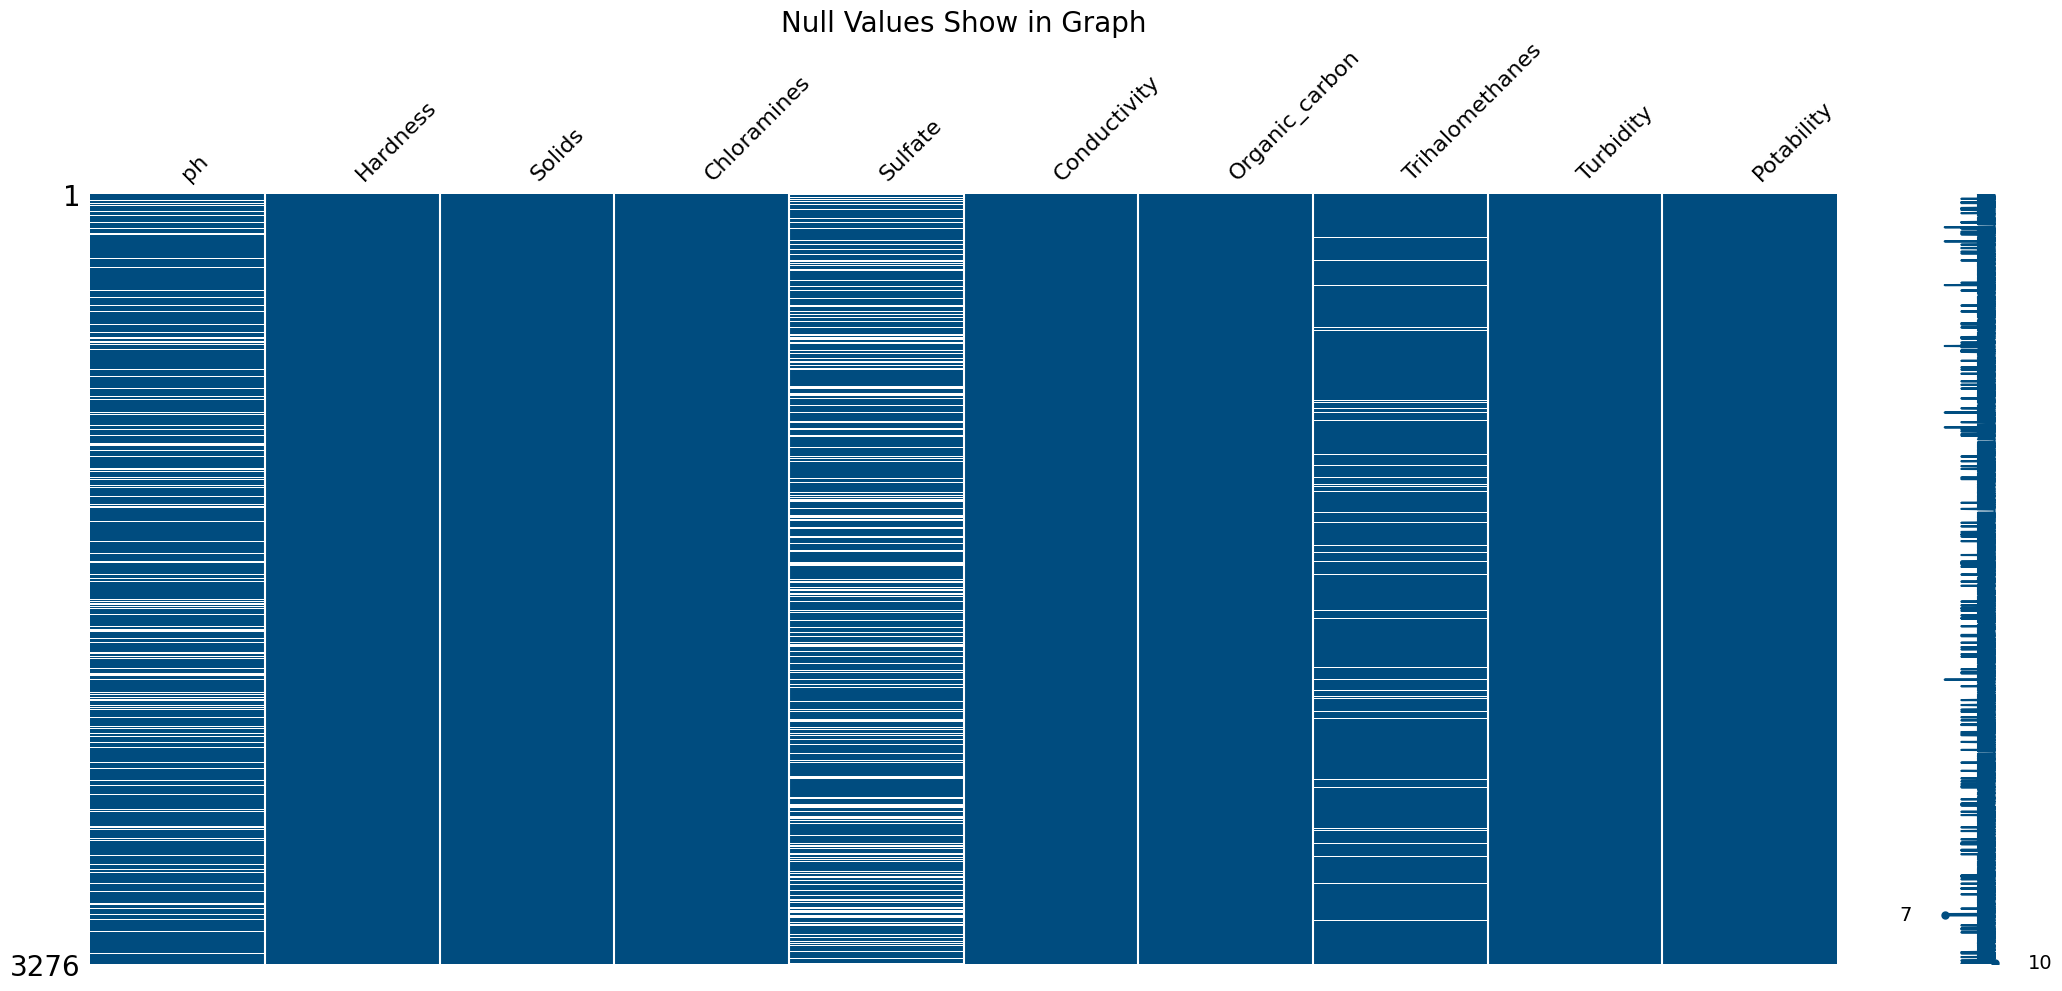

In [7]:
#矩阵图查看缺失是否和行绑定决定删除行还是补充列
#组合分析数据清洗更精准后续建模稳
msno.matrix(data, color=(0,0.3,0.5))
plt.title('Null Values Show in Graph', fontsize=20)
plt.show()

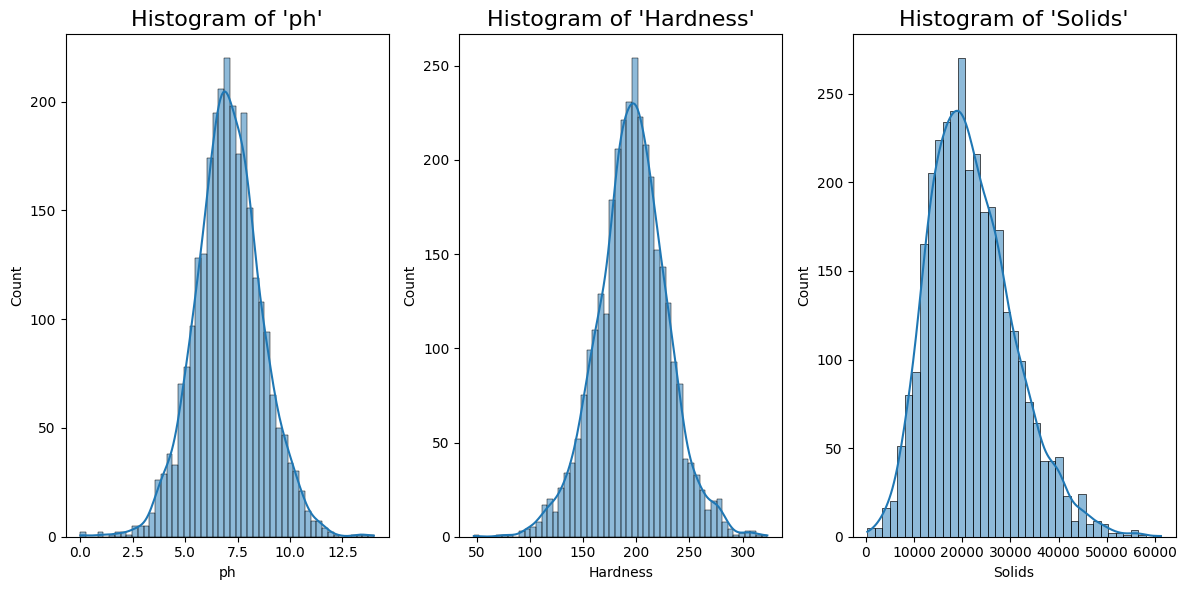

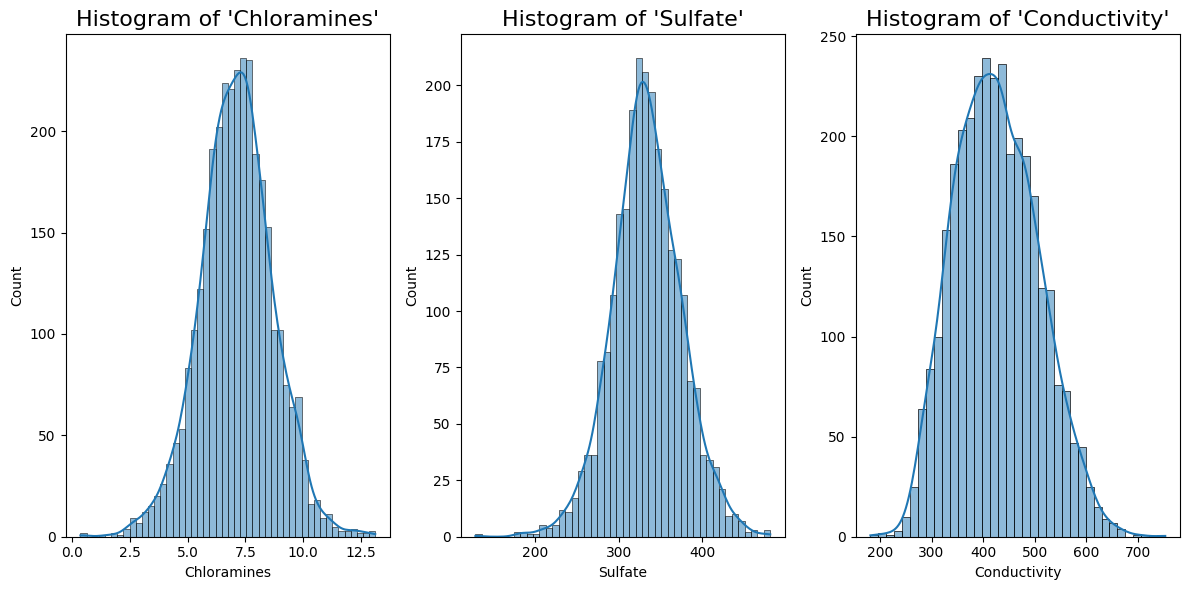

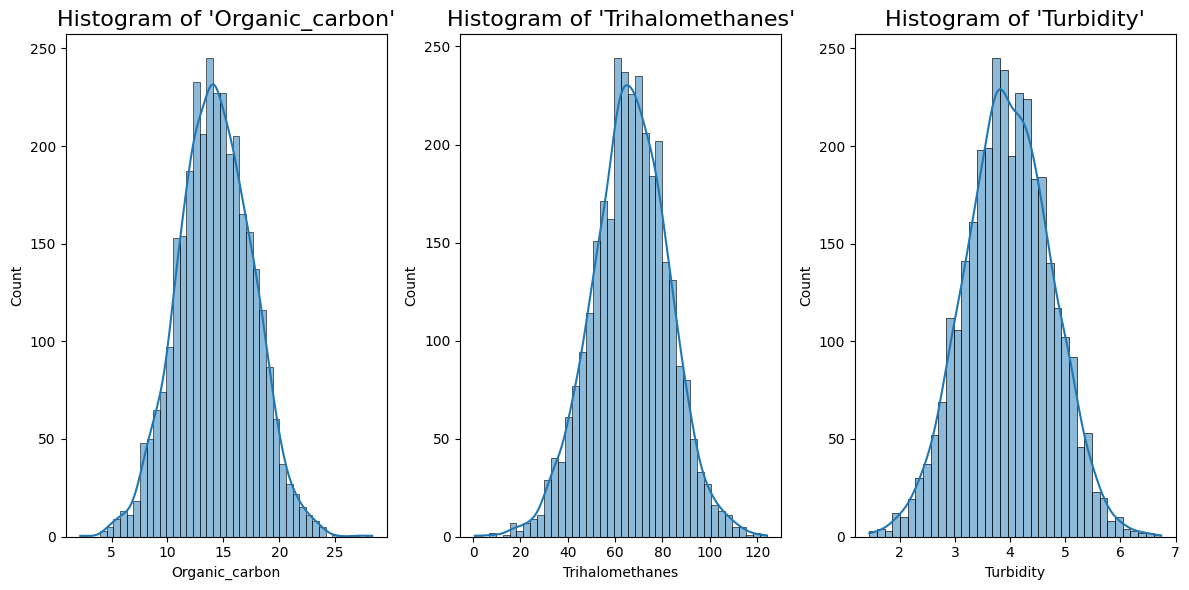

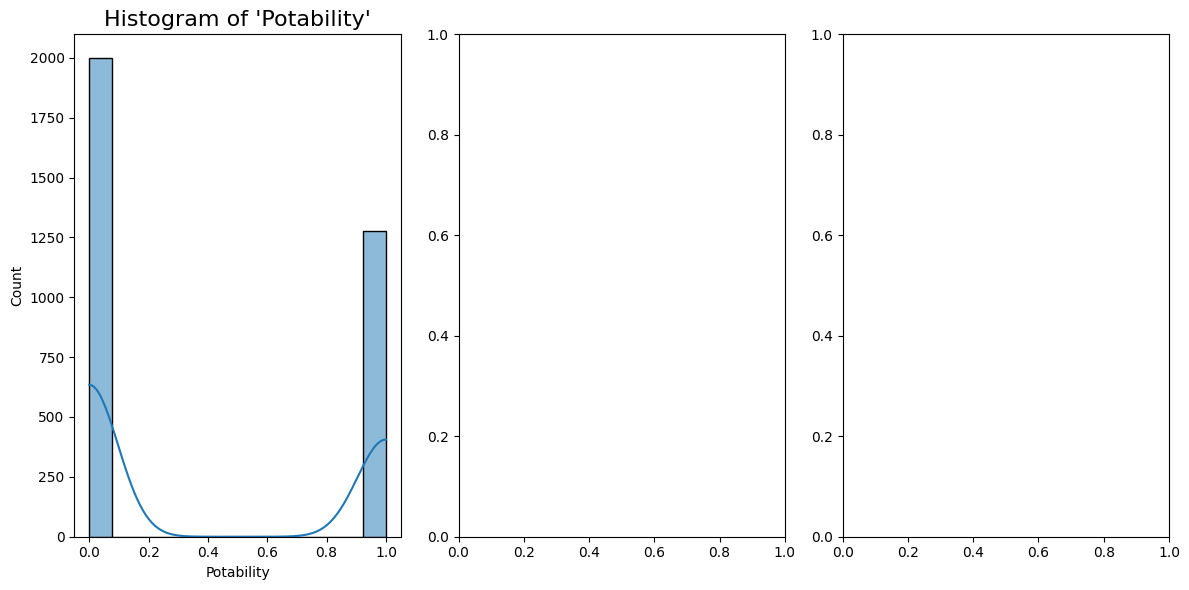

In [8]:
#直方图查看数据指标是否正常
#加入正态分布
cols = data.columns

#指标多用循环效率高
for i in range (4):
#创建一行三列子图
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, figsize=(12,6))

    ax1 = sns.histplot(data[cols[i*3]], ax=ax1,kde=True)
    ax1.set_title(f"Histogram of '{cols[i*3]}'", size=16)

    if i < 3:
        ax2 = sns.histplot(data[cols[i*3+1]], ax=ax2,kde=True)
        ax2.set_title(f"Histogram of '{cols[i*3+1]}'", size=16)
        ax3 = sns.histplot(data[cols[i*3+2]], ax=ax3,kde=True)
        ax3.set_title(f"Histogram of '{cols[i*3+2]}'", size=16)
#自动优化
    plt.tight_layout()
   

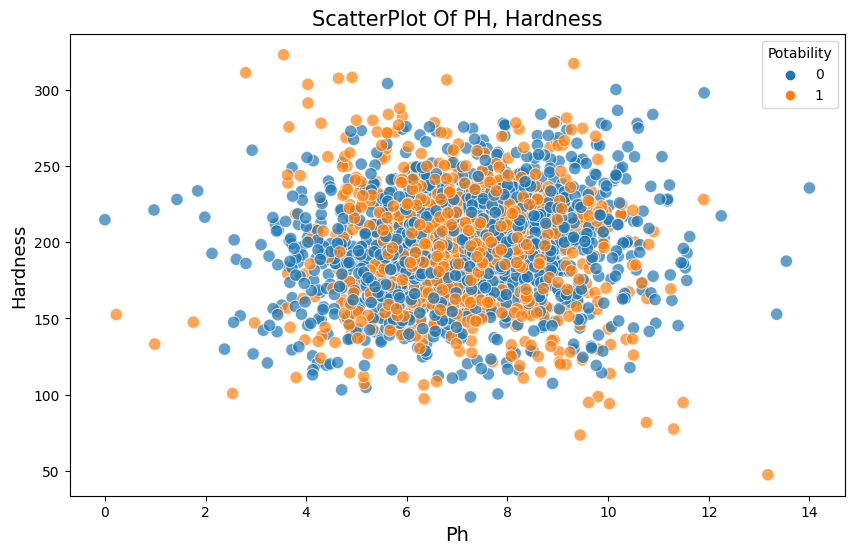

In [9]:
#查看ph和硬度是否具有关联
plt.figure(figsize=(10,6))
sns.scatterplot(x=data['ph'], y=data['Hardness'], s=80,alpha=0.7, hue=data['Potability'])
plt.title('ScatterPlot Of PH, Hardness', fontsize=15)
plt.xlabel('Ph', fontsize=14)
plt.ylabel('Hardness', fontsize=13)

plt.show()


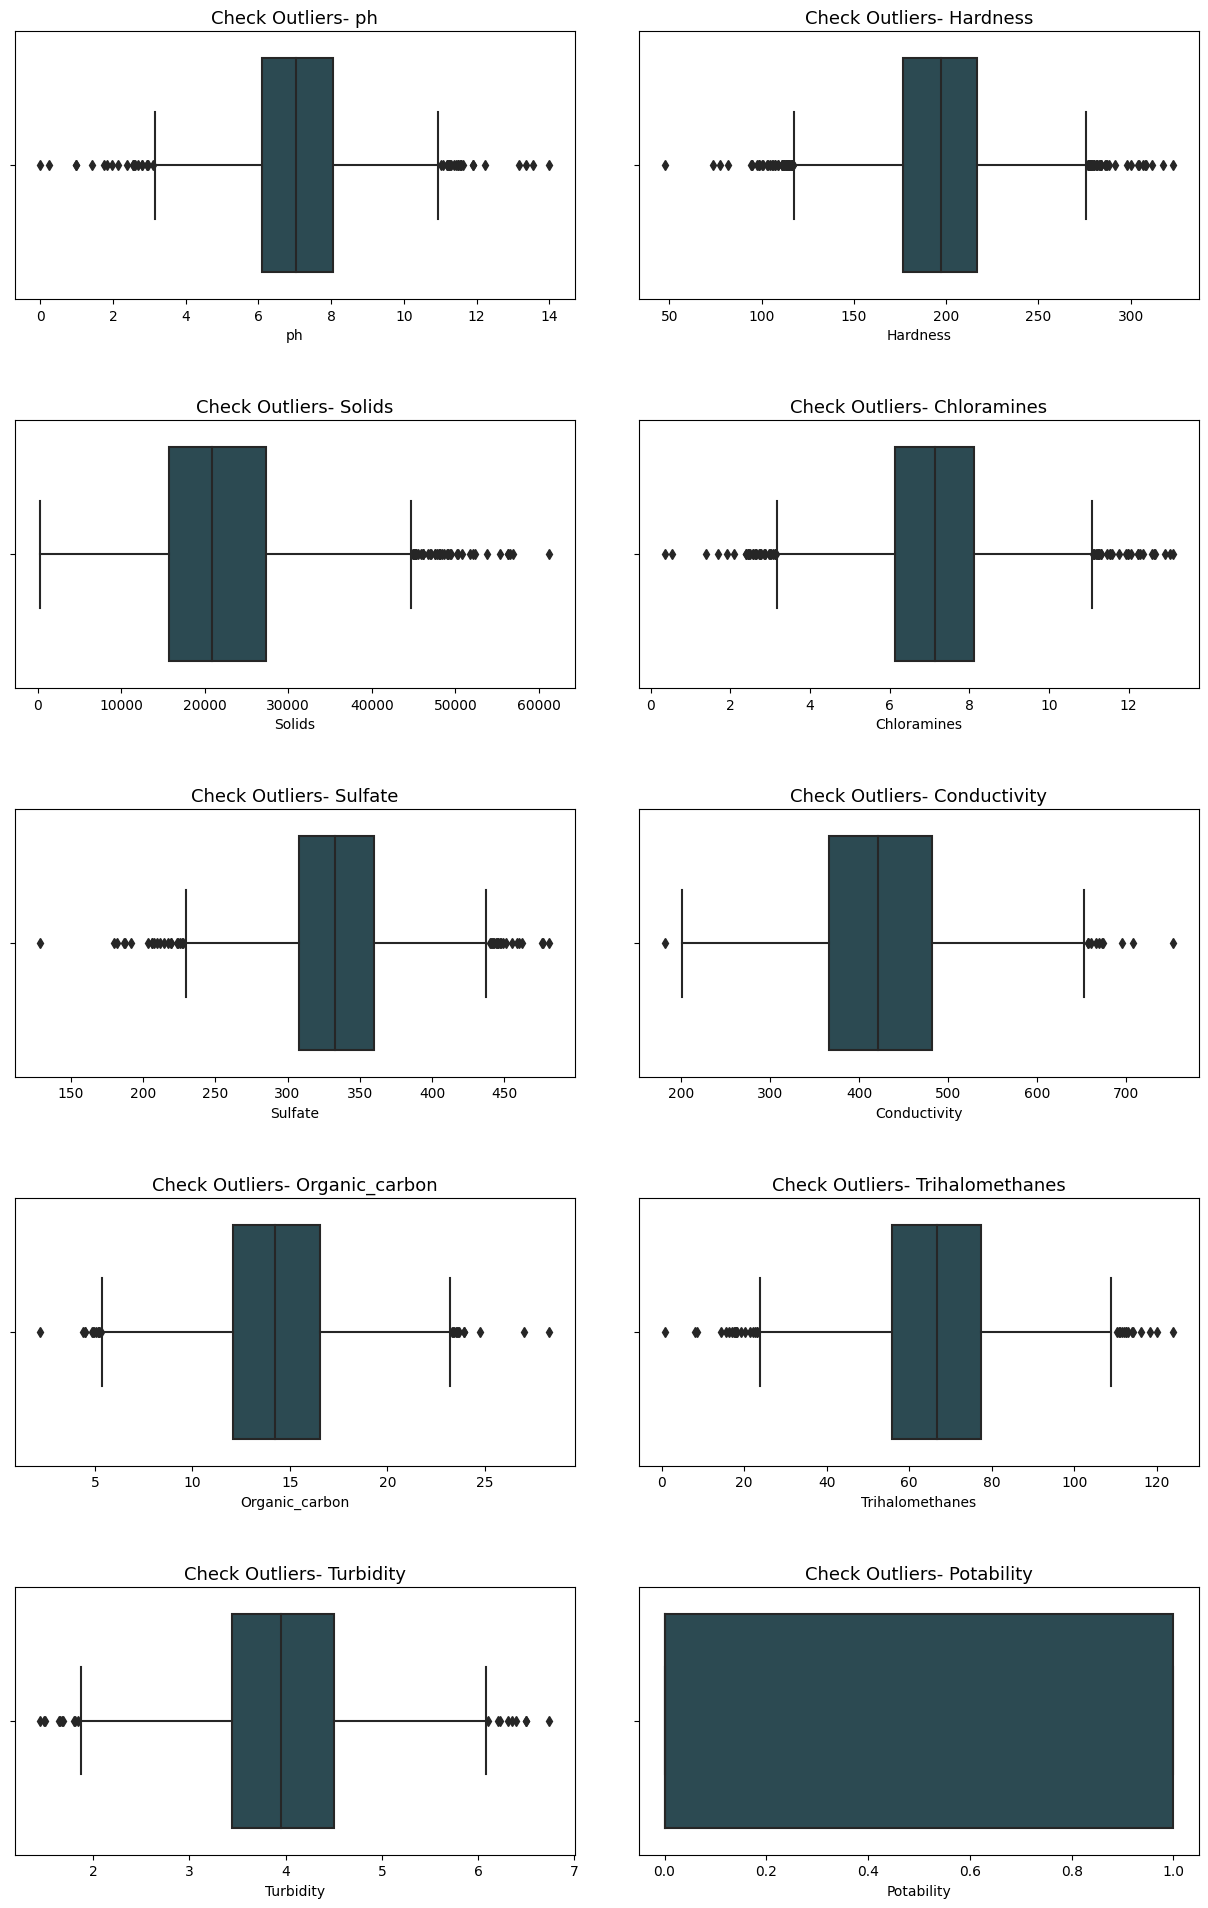

In [10]:
#利用箱线图查看异常值
plt.figure(figsize=(13,20))
for k, cols in enumerate(data):
    plt.subplot(5,2, k+1)
    sns.boxplot(x=cols,data=data,color='#264D58')
    plt.title(f"Check Outliers- {cols}", fontsize=13)
    plt.tight_layout(pad=4.0)
    
plt.show()

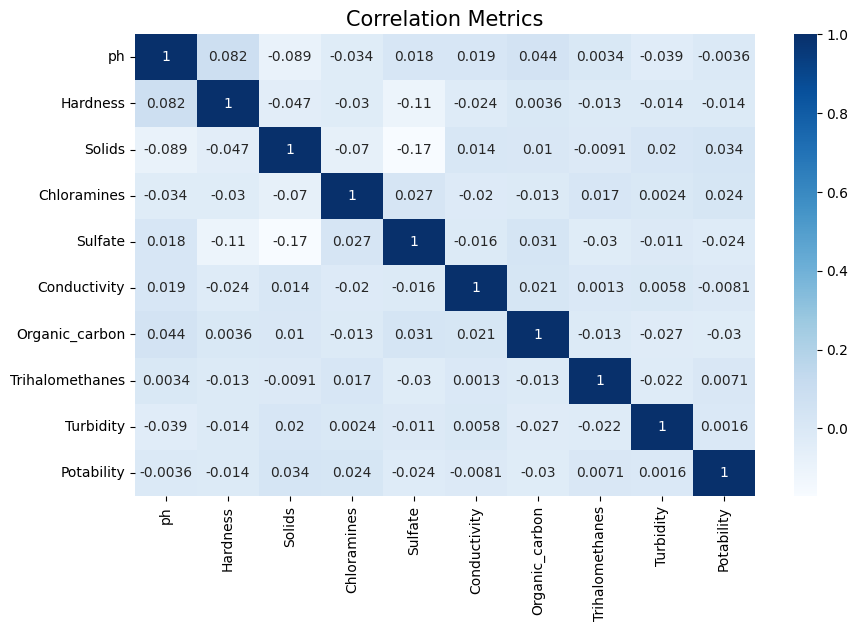

In [11]:
#特征关系挖掘，相关性热力图 heatmap分析水质特征间关联关系防止过度拟合
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, cmap='Blues')
plt.title('Correlation Metrics', fontsize=15)
plt.show()

In [12]:
#处理数据缺失值中位数填充分组填充
for col in ['ph', 'Sulfate', 'Trihalomethanes']:
    # 计算分组中位数
    group_median = data.groupby('Potability')[col].transform('median')
    data[col].fillna(group_median, inplace=True)
print(data[['ph', 'Sulfate', 'Trihalomethanes']].isnull().sum())


ph                 0
Sulfate            0
Trihalomethanes    0
dtype: int64


In [13]:
#划分特征和标签为后续建模准备--特征工程
X= data.drop(columns='Potability', axis=1)
y= data['Potability']

In [14]:
#将特征矩阵 X 和目标向量 y 按照指定比例划分为训练集和测试集
X_train,X_test, y_train,y_test = train_test_split(X,y , test_size=0.3)

print(f"X_train Shape: {X_train.shape}")
print(f"Y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (2293, 9)
Y_train Shape: (2293,)
X_test Shape: (983, 9)
y_test Shape: (983,)


In [15]:
# 创建StandardScaler对象，用于特征标准化
scaler = StandardScaler()
#仅使用训练数据计算均值和标准差
scaler.fit(X_train,)
# 应用标准化变换到训练数据
X_train_scaled  = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [16]:
#储存多种算法模型（逻辑回归，随机森林，集中学习中的bagging
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Bagging Classifier': BaggingClassifier(),
    'Adaboost Classifier': AdaBoostClassifier(),
    'Gradeint Boosting Classifier': GradientBoostingClassifier(),
    'SVC': SVC(),
    'XGBoost Classifier': XGBClassifier()}

 Model Name: Logistic Regression
Accuracy Score: 0.60
Precision Score: 0.5491845056065239
__________________________________________________



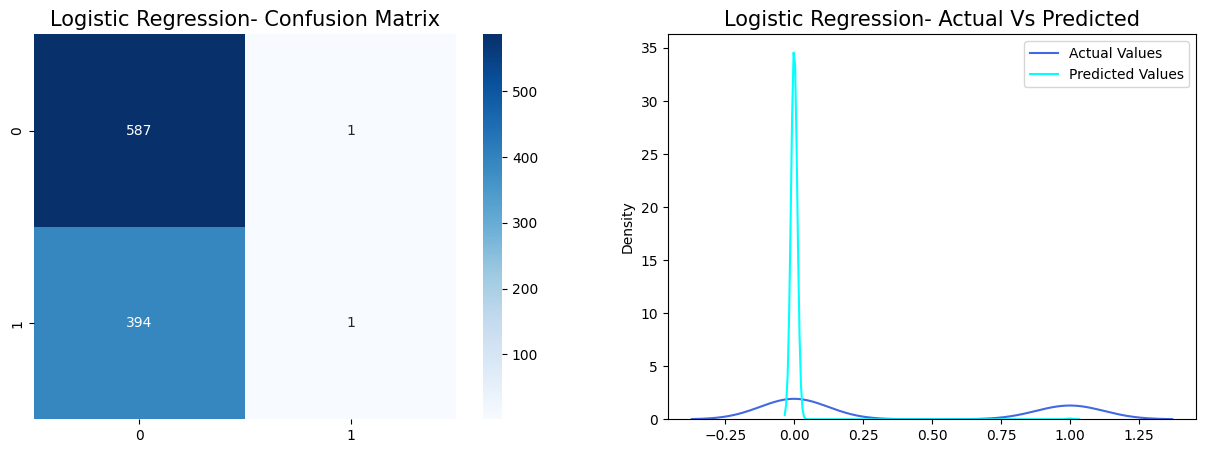

 Model Name: Random Forest
Accuracy Score: 0.78
Precision Score: 0.7785070121135695
__________________________________________________



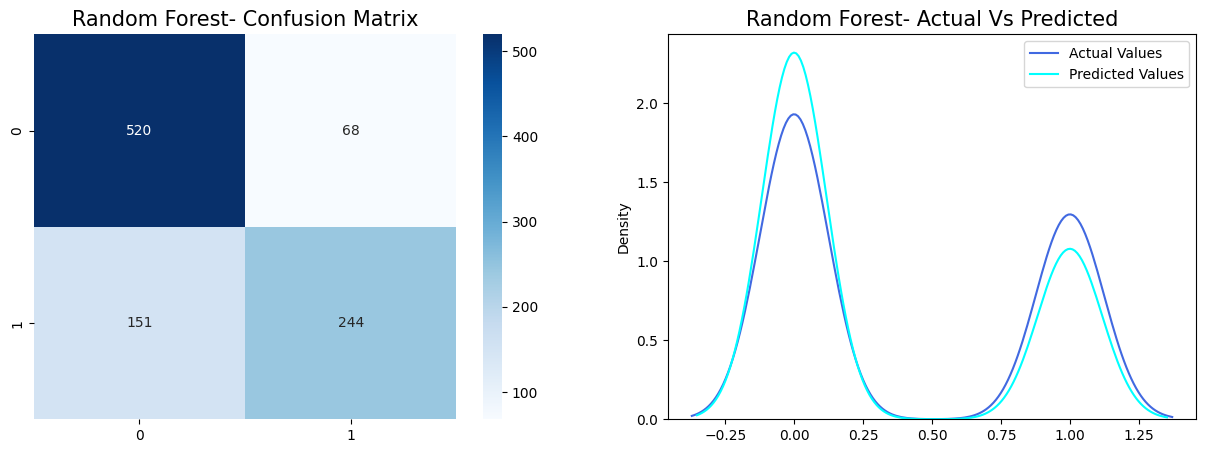

 Model Name: Bagging Classifier
Accuracy Score: 0.75
Precision Score: 0.7491961034662127
__________________________________________________



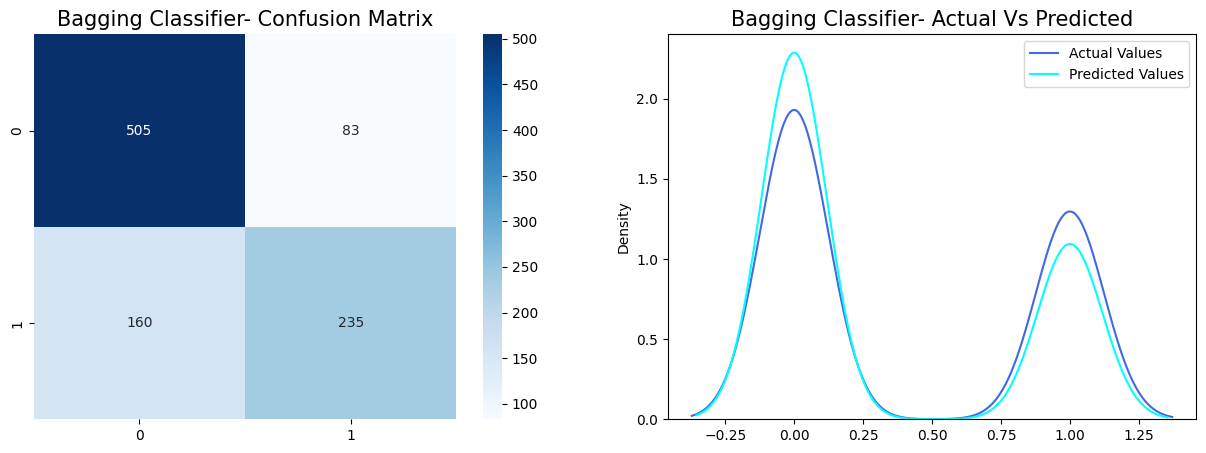

 Model Name: Adaboost Classifier
Accuracy Score: 0.73
Precision Score: 0.7466520082087365
__________________________________________________



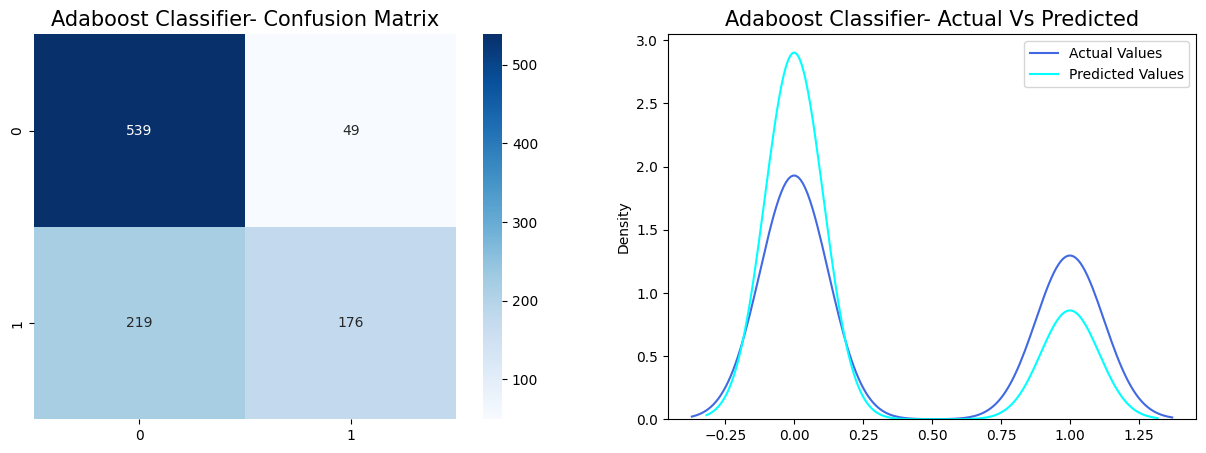

 Model Name: Gradeint Boosting Classifier
Accuracy Score: 0.78
Precision Score: 0.7892396913749227
__________________________________________________



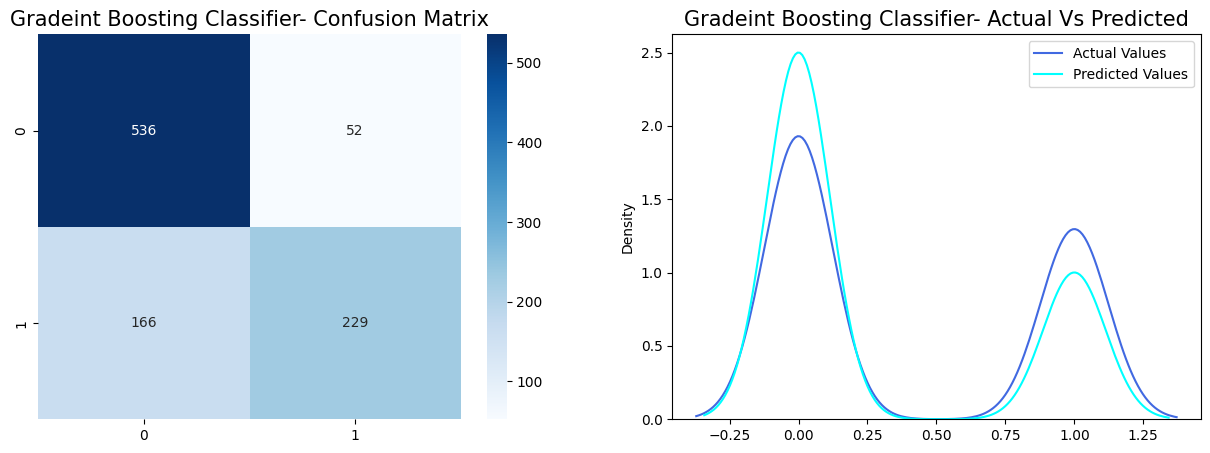

 Model Name: SVC
Accuracy Score: 0.69
Precision Score: 0.7108334137033108
__________________________________________________



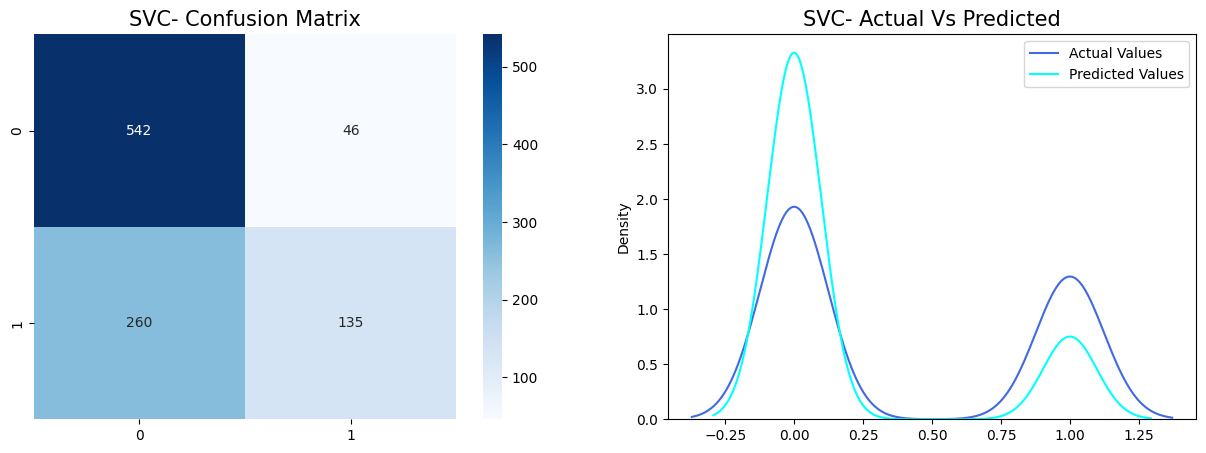

 Model Name: XGBoost Classifier
Accuracy Score: 0.77
Precision Score: 0.7707907293796865
__________________________________________________



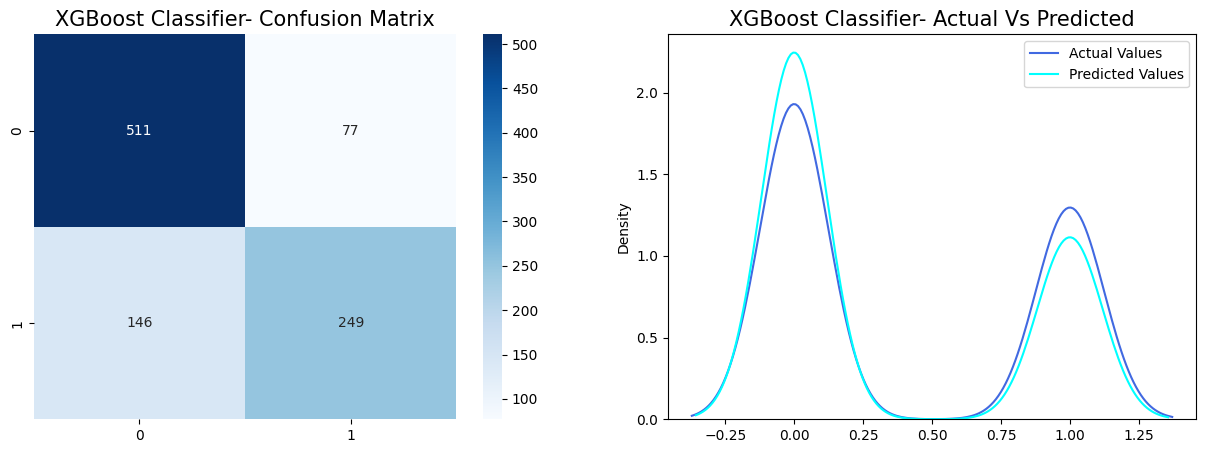

In [20]:
for name, model in models.items():
    # 使用训练数据拟合模型
    model.fit(X_train_scaled, y_train)
    # 对测试数据进行预测
    y_preds = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_preds)
    precision= precision_score(y_test, y_preds, average='macro')
    
    print(f' Model Name: {name}')
    print(f'Accuracy Score: {accuracy:.2f}')
    print(f'Precision Score: {precision}')
    print('_' * 50)
    print()
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, y_preds)
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    # 修改点1: 热力图的色板改为冷色系 (Blues)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')  # 添加fmt='d'显示整数
    plt.title(f'{name}- Confusion Matrix', fontsize=15)  # 修正拼写错误
    
    plt.subplot(1, 2, 2)
    # 修改点2: 密度图使用冷色系配色
    sns.kdeplot(y_test.values, color='royalblue', label='Actual Values')  # 深蓝色
    sns.kdeplot(y_preds, color='cyan', label='Predicted Values')          # 青色
    plt.title(f'{name}- Actual Vs Predicted', fontsize=15)
    plt.legend()
    plt.show()
